In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scrape
import search
import visualize

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_content_from_article(url: str) -> str:
    document = requests.get(url).text
    _, parsed_text = scrape.parse_content_from_bs(BeautifulSoup(document))
    return parsed_text

docs_df = pd.read_parquet("related_large_set.pq")[:750]
texts = docs_df.text.tolist()
texts = [text.replace(";", " ") for text in texts]

In [5]:
engine = search.SimpleSearcheEngine()
engine.compile_index(texts, docs_df.url.tolist())

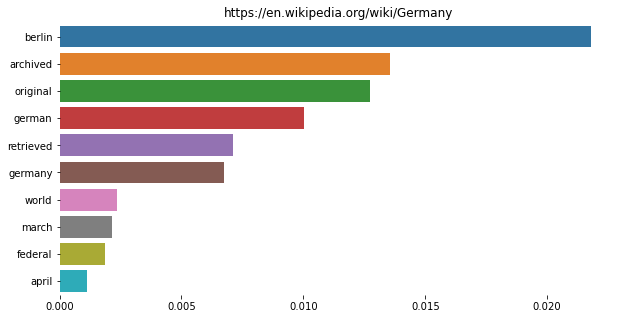

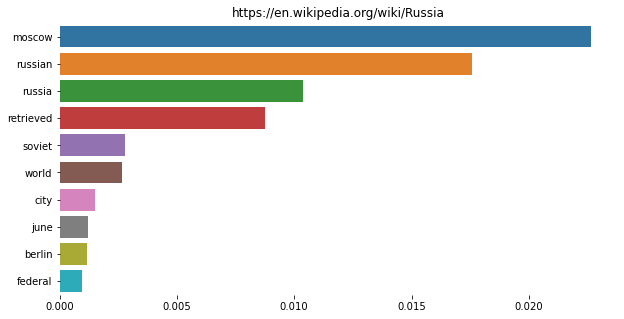

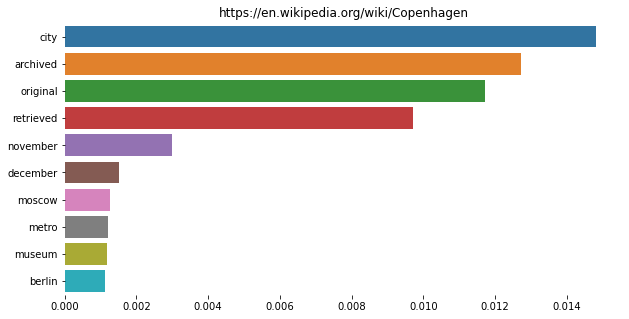

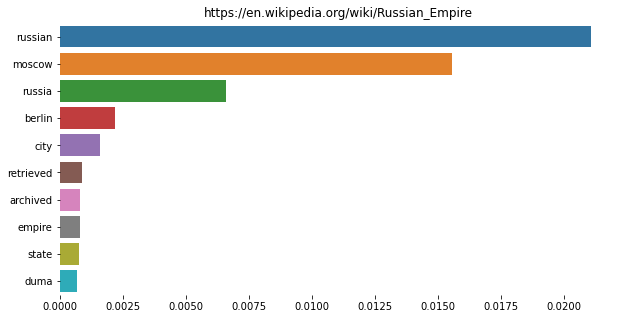

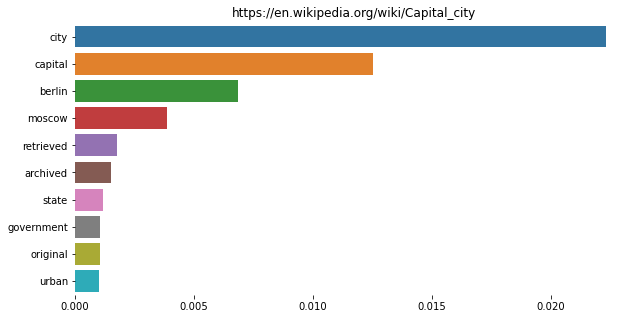

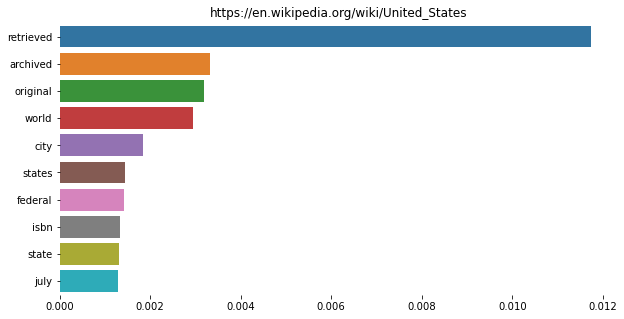

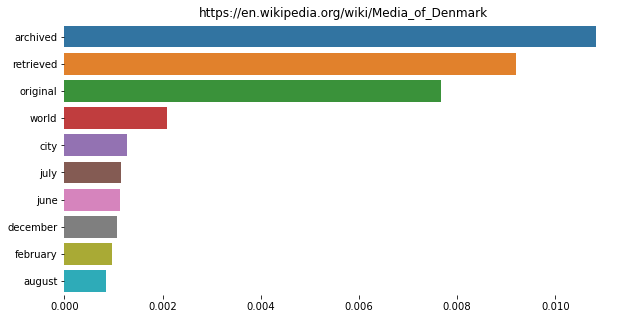

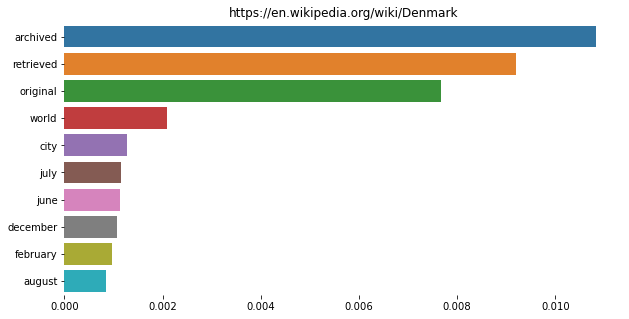

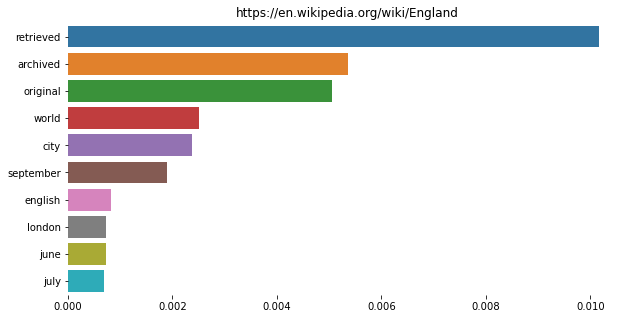

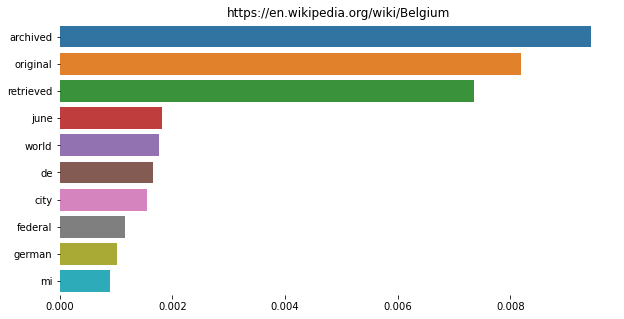

In [6]:
urls = ["https://en.wikipedia.org/wiki/Berlin", "https://en.wikipedia.org/wiki/Moscow"]
queries = [get_content_from_article(url) for url in urls]

scores_df = engine.get_scores_dataframe_from_queries(queries, top_n=10)
visualize.visualize_top_scores(scores_df, 10)